In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.data import AUTOTUNE
from sklearn.utils import compute_class_weight
from keras.src.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from keras.src.optimizers.adamw import AdamW
import os
import matplotlib.pyplot as plt
import keras_tuner as kt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

ImportError: cannot import name 'MobileNetV2' from 'keras.src.applications' (C:\Users\PC\IdeaProjects\Devops\venv\lib\site-packages\keras\src\applications\__init__.py)

In [18]:
ruta_dataset = '../data/data-xray/224/224'
clases = sorted(os.listdir(ruta_dataset))
print(f"Clases detectadas ({len(clases)}): {clases}\n")
conteo = {}
for clase in clases:
    ruta_clase = os.path.join(ruta_dataset, clase)
    if os.path.isdir(ruta_clase):
        cantidad = len([
            f for f in os.listdir(ruta_clase)
            if os.path.isfile(os.path.join(ruta_clase, f))
        ])
        conteo[clase] = cantidad

for clase, cantidad in conteo.items():
    print(f"Clase '{clase}': {cantidad} imágenes")

Clases detectadas (2): ['Normal', 'Scol']

Clase 'Normal': 71 imágenes
Clase 'Scol': 188 imágenes


In [19]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 123

In [20]:
train_data_set = image_dataset_from_directory(
    ruta_dataset,
    validation_split = validation_split,
    subset = "training",
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
)

test_data_set = image_dataset_from_directory(
    ruta_dataset,
    validation_split = validation_split,
    subset = "validation",
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
)


Found 259 files belonging to 2 classes.
Using 208 files for training.
Found 259 files belonging to 2 classes.
Using 51 files for validation.


In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

normalization_layer = layers.Rescaling(1./255)


In [22]:
train_data_set = train_data_set.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y), num_parallel_calls=AUTOTUNE)

test_data_set = test_data_set.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls = AUTOTUNE)

train_data_set = train_data_set.prefetch(buffer_size = AUTOTUNE)
test_data_set = test_data_set.prefetch(buffer_size = AUTOTUNE)

In [23]:
#Calcular class_weight
y_train = np.concatenate([y.numpy() for _, y in train_data_set])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(clases)),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de la clase: {class_weights_dict}")

Pesos de la clase: {0: 1.7333333333333334, 1: 0.7027027027027027}


In [24]:
def build_model(hp):
    base_model = MobileNetV2( #modificable
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )

    unfreeze_layers = hp.Int('unfreeze_layers', min_value=20, max_value=150, step=20) #modificable 
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        layers.Dense(len(clases), activation='softmax')
    ])

    learning_rate = hp.Choice('learning_rate', [1e-5, 1e-4, 5e-5]) #modificable
    weight_decay = hp.Choice('weight_decay', [1e-4, 1e-5]) #modificable 

    model.compile(
        optimizer=AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [25]:
print("Iniciando búsqueda de hiperparámetros...")
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,
    executions_per_trial=1,
    directory='kerastuner_dir',
    project_name='efficientnet_brain_mri',
    overwrite=True
)

tuner.search(
    train_data_set,
    validation_data=test_data_set,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)   

Trial 7 Complete [00h 00m 37s]
val_accuracy: 0.5098039507865906

Best val_accuracy So Far: 0.9803921580314636
Total elapsed time: 00h 04m 46s


In [26]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(test_data_set)
print(f"Mejor modelo - Loss: {loss}, Accuracy: {accuracy:.4f}")

2/2 [==============================] - 1s 123ms/step - loss: 0.0610 - accuracy: 0.9804
Mejor modelo - Loss: 0.06100419536232948, Accuracy: 0.9804


In [27]:
history = best_model.fit(
    train_data_set,
    validation_data=test_data_set,
    epochs=20, #modificable
    class_weight=class_weights_dict,    
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]    
)

Epoch 1/20
7/7 [==============================] - 13s 603ms/step - loss: 0.0590 - accuracy: 0.9760 - val_loss: 0.3511 - val_accuracy: 0.8627
Epoch 2/20
7/7 [==============================] - 4s 604ms/step - loss: 0.0463 - accuracy: 0.9856 - val_loss: 0.8461 - val_accuracy: 0.7843
Epoch 3/20
7/7 [==============================] - 4s 591ms/step - loss: 0.0273 - accuracy: 0.9904 - val_loss: 1.0678 - val_accuracy: 0.7843
Epoch 4/20
7/7 [==============================] - 4s 587ms/step - loss: 0.0646 - accuracy: 0.9808 - val_loss: 1.0541 - val_accuracy: 0.7843
Epoch 5/20
7/7 [==============================] - 4s 607ms/step - loss: 0.0192 - accuracy: 0.9904 - val_loss: 1.0175 - val_accuracy: 0.7843
Epoch 6/20
7/7 [==============================] - 4s 599ms/step - loss: 0.0287 - accuracy: 0.9952 - val_loss: 1.1015 - val_accuracy: 0.7843


In [28]:
loss, accuracy = best_model.evaluate(test_data_set)
print(f"Evaluación final - Loss: {loss}, Accuracy: {accuracy:.4f}")

2/2 [==============================] - 0s 121ms/step - loss: 0.3511 - accuracy: 0.8627
Evaluación final - Loss: 0.351095050573349, Accuracy: 0.8627


   Trial  Val_Accuracy  Accuracy  unfreeze_layers  dropout  learning_rate  \
0      0      0.980392  0.971154              140      0.2        0.00010   
1      1      0.764706  0.687500               80      0.2        0.00001   
3      3      0.647059  0.639423               20      0.3        0.00005   
2      2      0.529412  0.538462               80      0.3        0.00001   
6      6      0.509804  0.677885              120      0.3        0.00001   
4      4      0.431373  0.764423              120      0.2        0.00005   
5      5      0.294118  0.336538               20      0.3        0.00001   

   weight_decay  
0       0.00001  
1       0.00001  
3       0.00010  
2       0.00001  
6       0.00010  
4       0.00001  
5       0.00001  


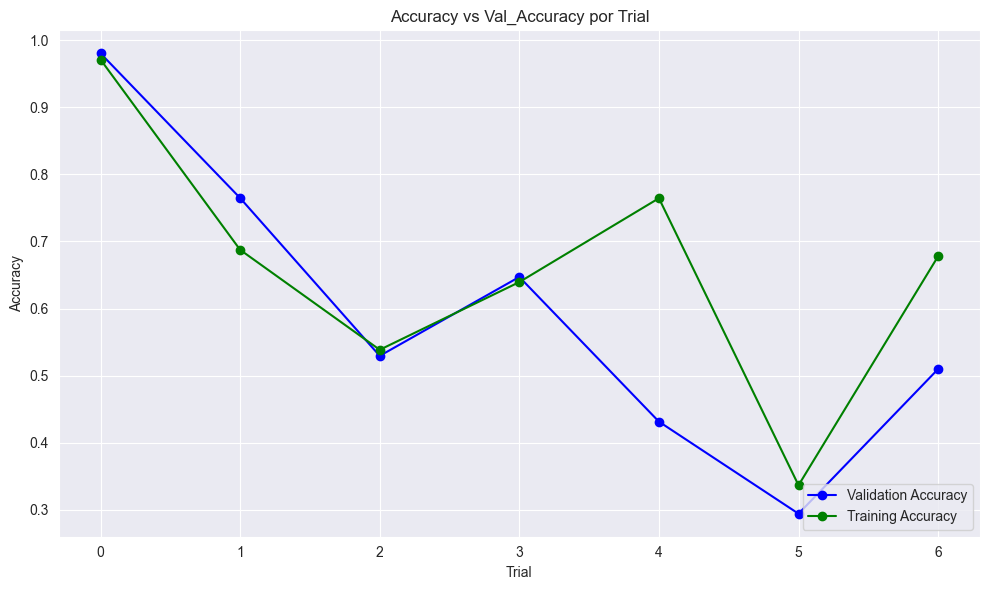

In [29]:
trials = tuner.oracle.trials.values()

results = []
for i, trial in enumerate(trials):
    result = {
        'Trial': i,
        'Val_Accuracy': trial.metrics.get_best_value('val_accuracy'),
        'Accuracy': trial.metrics.get_best_value('accuracy'),
        **trial.hyperparameters.values 
    }
    results.append(result)

df = pd.DataFrame(results)

df_sorted = df.sort_values(by='Val_Accuracy', ascending=False)
print(df_sorted)

plt.figure(figsize=(10, 6))
plt.plot(df['Trial'], df['Val_Accuracy'], marker='o', label='Validation Accuracy', color='blue')
plt.plot(df['Trial'], df['Accuracy'], marker='o', label='Training Accuracy', color='green')
plt.title('Accuracy vs Val_Accuracy por Trial')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 548ms/step


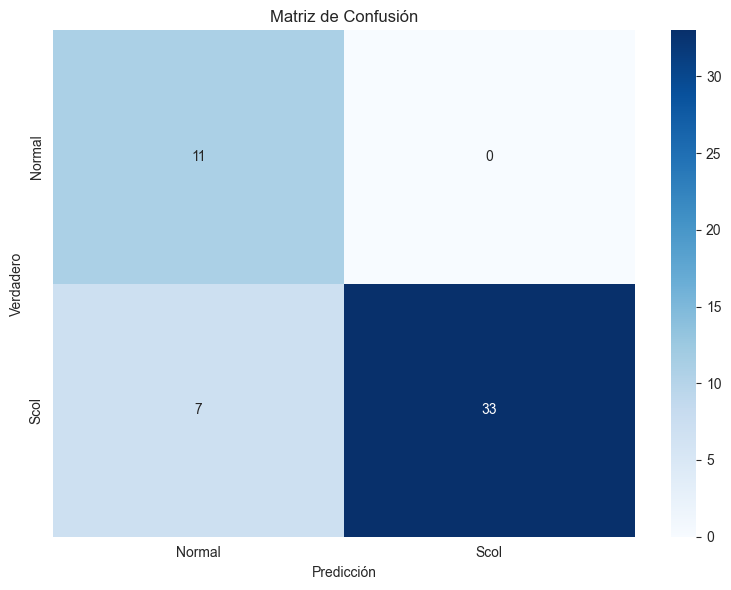

Informe de Clasificación:

              precision    recall  f1-score   support

      Normal       0.61      1.00      0.76        11
        Scol       1.00      0.82      0.90        40

    accuracy                           0.86        51
   macro avg       0.81      0.91      0.83        51
weighted avg       0.92      0.86      0.87        51



In [30]:
#matriz de confusion
y_true = []
y_pred = []

for images, labels in test_data_set:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# Informe de clasificación
print("Informe de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=clases))

In [32]:
#curva ROC
y_true = []
y_pred = []

for images, labels in test_data_set:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Binarizar etiquetas (One-hot) para ROC multiclase
y_true_bin = label_binarize(y_true, classes=range(len(clases)))

# Calcular ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clases)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar la curva ROC para cada clase
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(len(clases)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 176ms/step


IndexError: index 1 is out of bounds for axis 1 with size 1

1/1 [==============================] - 0s 322ms/step


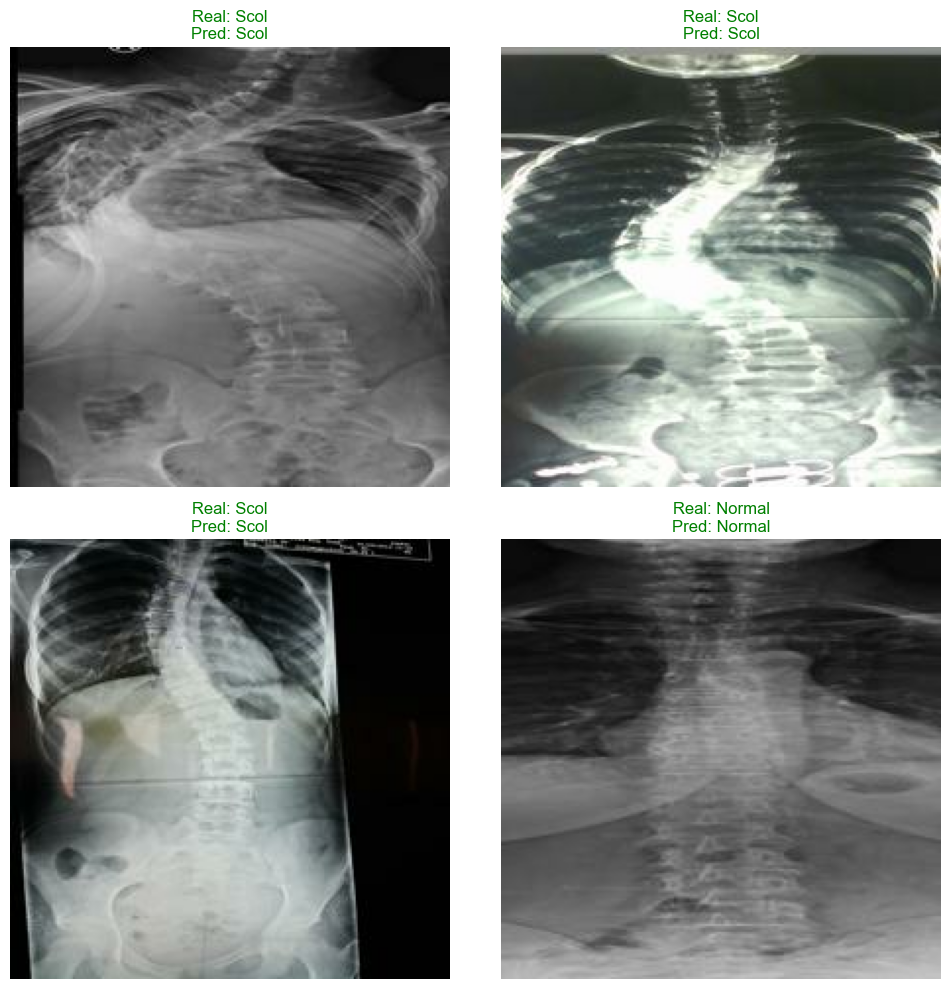

In [33]:
for images, labels in test_data_set.take(1):
    # Predecir sobre las imágenes
    predictions = best_model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    # Mostrar las primeras 4 imágenes con etiquetas
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy())
        true_label = clases[labels[i].numpy()]
        pred_label = clases[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()